# Final Project
The goal of the project is to explore a number of datasets that may be associated with political instability in the U.S. The data was taken from the Seshat Databank under Creative Commons Attribution Non-Commercial (CC By-NC SA) licensing. You are asked to follow the steps and/or answer the questions below. It is permitted to work on the project in pairs or individually (1-2 students per project). If working in a group, please ensure that you include the names of both team members in your submission and on the document itself!

### Group Members
- Yordi Hernandez
- Dariel Cruz Rodriguez

***

In [2]:
# Put any modules we need to import here so it all loads at the start of the code.

import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
plt.style.use('ggplot')

## Data Wrangling

* [X] Read the (short) code book.
* [X] Numerical data need to be uploaded, interpolated, and properly saved. For the purpose
of this project, interpolate each variable such that you obtain one point per year (within
the range of available data).
* [X] Calculate (and then interpolate) the political instability index.
* [x] Display the DataFrame with all of the columns and the interpolated data for the years
1901-1910.

In [4]:
# Yordi
# - PltEVI.csv
# - PltHeight.csv
# - PltHSUS.csv

In [7]:
dataframes = {
    "pltevi" : pd.read_csv("files/PltEVI.csv", header=None),
    "pltheight" : pd.read_csv("files/PltHeight.csv", header=None),
    "plthsus" : pd.read_csv("files/PltHSUS.csv", header=None),
}

column_mappings = {
    "pltevi": ["time", "EVI"],
    "pltheight": ["time", "Height(cm)"],
    "plthsus": ["time", "HSUS"],
}

for name, df in dataframes.items():
    df.columns = column_mappings[name] 
    df = df.iloc[1:].reset_index(drop=True) 
    df["time"] = df["time"].astype(float).round().astype(int) 
    df[df.columns[1]] = df[df.columns[1]].astype(float) 
    df = df.drop_duplicates(subset=["time"])  
    df = df.set_index("time").reindex(range(df["time"].min(), df["time"].max() + 1)).interpolate()
    df.reset_index(inplace=True)
    dataframes[name] = df

filtered_data = {name: df for name, df in dataframes.items()}

yordi_joined = filtered_data["pltheight"].merge(filtered_data["pltevi"], on="time").merge(filtered_data["plthsus"], on="time")

In [9]:
yordi_joined.head(1)

,time,Height(cm),EVI,HSUS
0,1793,172.892156,27.356603,17.984565


In [11]:
# Dariel
# - PltPolarizaiton.csv
# - PltWageGDPRatio.csv
# - USPVdatabase.xlsx

pltpolar = pd.read_csv("files/PltPolarization.csv", header=None, names=["year", "polarization"])
pltwage = pd.read_csv("files/PltWageGDPRatio.csv", header=None, names=["year", "ratio"])
uspv = pd.read_csv("files/USPVdatabase.csv")


In [13]:
# Dariel

#####################################
# Political Polarizaiton (pltpolar) #
#####################################

# Interpolating pltpolar by taking the mean so we have exactly one data point per year
# Structure: year, distance between the average scores of the Democrats/Republicans for each Congress
pltpolar["time"] = np.floor(pltpolar["year"])
pltpolar = pltpolar.groupby("time")["polarization"].mean().reset_index()
pltpolar["time"] = pltpolar["time"].apply(lambda x : int(x))

######################################
# Political Wage/GDP Ratio (pltwage) #
######################################

# Interpolating pltwage by taking the mean so we have exactly one data point per year
# Structure: year, ratio of blue collar wages/gdp per year
pltwage["time"] = np.floor(pltwage["year"])
pltwage = pltwage.groupby("time")["ratio"].mean().reset_index()
pltwage["time"] = pltwage["time"].apply(lambda x : int(x))

######################################
# Political Violence Database (uspv) #
######################################
uspv = uspv.drop(columns=["code","source","description", "location"])
uspv["time"] = np.floor(uspv["year"])
uspv = uspv.dropna()
uspv["time"] = uspv["time"].apply(lambda x : int(x))

pivot_type = pd.crosstab(uspv['time'], uspv['type'])
uspv = pivot_type

######################################
# JOINING DARIEL'S DATASETS TOGETHER #
######################################

# We can merge with Yordi's datasets later on the time column
dariel_joined = pd.merge(pltpolar, pltwage, on="time", how="outer")
dariel_joined = pd.merge(dariel_joined, uspv, on="time", how="outer")
dariel_joined[["assassination", "executions", "insurrection", "lynching",
               "mass suicide", "rampage", "riot", "terrorism", "war"]] = \
dariel_joined[["assassination", "executions", "insurrection", "lynching",
               "mass suicide", "rampage", "riot", "terrorism", "war"]].fillna(0)

years_wanted = [1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910]
dariel_joined["time"] = dariel_joined["time"].apply(lambda x : str(x))
dariel_joined["ratio"] = dariel_joined["ratio"].interpolate(method='linear')
dariel_joined["total_deaths"] = dariel_joined[["assassination", "executions", "insurrection", "lynching",
                                               "mass suicide", "rampage", "riot", "terrorism", "war"]].sum(axis=1)
dariel_joined = dariel_joined.reset_index().drop(columns="index")

In [15]:
yordi_joined["time"] = yordi_joined["time"].astype(int)

In [17]:
# Once both of us have wrangled our data, uncomment this and boom we have our data

yordi_joined["time"] = yordi_joined["time"].astype(int)
dariel_joined["time"] = dariel_joined["time"].astype(int)


df = pd.merge(dariel_joined, yordi_joined, left_on="time", right_on="time", how="outer")

In [19]:
df = df[(df['time'] >= 1815) & (df['time'] <= 1968)].reset_index().drop(columns="index")
df["polarization"] = df["polarization"].interpolate(method='linear')
#1793-1970 to avoid missing values

In [21]:
df_filtered = df[(df['time'] >= 1901) & (df['time'] <= 1910)].reset_index().drop(columns="index")
df_filtered

,time,polarization,ratio,assassination,executions,insurrection,lynching,mass suicide,rampage,riot,terrorism,war,total_deaths,Height(cm),EVI,HSUS
0,1901,0.845472,0.651275,1.0,0.0,0.0,3.0,0.0,0.0,5.0,0.0,0.0,9.0,170.147403,1414.866130,30.663260
1,1902,0.860217,0.645180,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,5.0,170.381602,1474.485794,31.272835
2,1903,0.868912,0.639086,0.0,0.0,0.0,5.0,0.0,0.0,9.0,0.0,0.0,14.0,170.618785,1601.367749,31.312078
3,1904,0.877794,0.627711,0.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,9.0,170.726188,1667.193907,31.879503
4,1905,0.890111,0.606085,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,170.940995,1811.854852,32.514036
5,1906,0.898414,0.596688,0.0,0.0,0.0,3.0,0.0,0.0,10.0,0.0,0.0,13.0,171.161172,1888.826416,33.091095
6,1907,0.891646,0.607063,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,6.0,171.384034,1965.170701,33.132955
7,1908,0.882256,0.610940,0.0,0.0,0.0,9.0,0.0,0.0,5.0,0.0,0.0,14.0,171.621216,2137.097683,33.724216
8,1909,0.873668,0.608747,0.0,0.0,0.0,7.0,0.0,0.0,1.0,0.0,0.0,8.0,171.836023,2227.886274,34.314315
9,1910,0.860964,0.602996,0.0,0.0,0.0,5.0,0.0,0.0,19.0,1.0,0.0,25.0,172.080664,2325.601346,34.346872


## Exploratory Data Analysis
* [ ] Conduct an exploratory data analysis
* [ ] Summarize your main findings (most interesting/insightful conclusions) in a short paragraph and include appropriate visualizations.

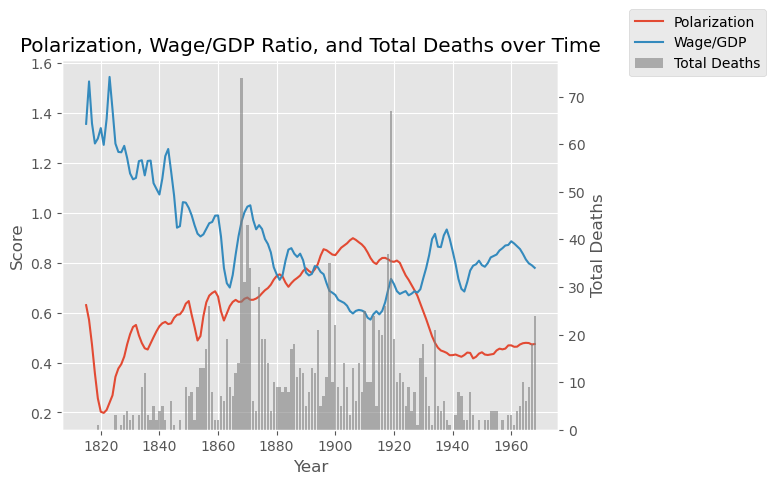

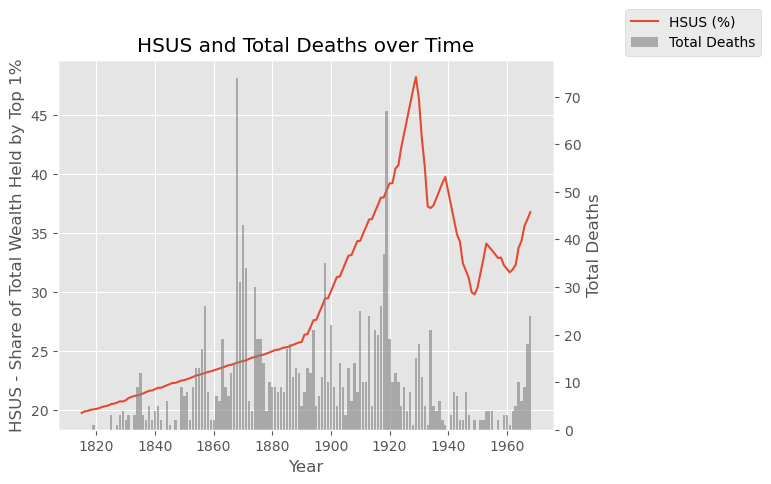

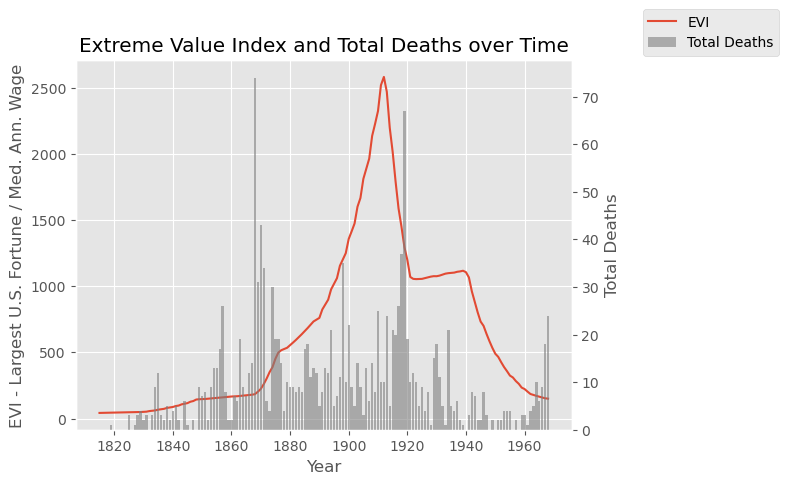

In [24]:
# Dariel

fig, ax1 = plt.subplots()

ax1.set_xlabel("Year")
ax1.set_ylabel("Score")
ax1.plot("time", "polarization", data=df, label="Polarization")
ax1.plot("time", "ratio", data=df, label="Wage/GDP")

ax2 = ax1.twinx()
ax2.set_ylabel("Total Deaths")
ax2.bar("time", "total_deaths", data=df, alpha=0.6, color='gray', label="Total Deaths")

plt.title("Polarization, Wage/GDP Ratio, and Total Deaths over Time")
plt.grid()
fig.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

##############

fig, ax1 = plt.subplots()

ax1.set_xlabel("Year")
ax1.set_ylabel("HSUS - Share of Total Wealth Held by Top 1%")
ax1.plot("time", "HSUS", data=df, label="HSUS (%)")

ax2 = ax1.twinx()
ax2.set_ylabel("Total Deaths")
ax2.bar("time", "total_deaths", data=df, alpha=0.6, color='gray', label="Total Deaths")

plt.title("HSUS and Total Deaths over Time")
plt.grid()
fig.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

##############

fig, ax1 = plt.subplots()

ax1.set_xlabel("Year")
ax1.set_ylabel("EVI - Largest U.S. Fortune / Med. Ann. Wage")
ax1.plot("time", "EVI", data=df, label="EVI")

ax2 = ax1.twinx()
ax2.set_ylabel("Total Deaths")
ax2.bar("time", "total_deaths", data=df, alpha=0.6, color='gray', label="Total Deaths")

plt.title("Extreme Value Index and Total Deaths over Time")
plt.grid()
fig.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

In [25]:
df.describe()

,time,polarization,ratio,assassination,executions,insurrection,lynching,mass suicide,rampage,riot,terrorism,war,total_deaths,Height(cm),EVI,HSUS
count,154.000000,154.000000,154.000000,154.000000,154.0,154.0,154.000000,154.0,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,1891.500000,0.603831,0.888165,0.279221,0.0,0.0,2.863636,0.0,0.123377,6.019481,0.038961,0.045455,9.370130,173.005306,643.338373,28.997821
std,44.600075,0.167190,0.215512,1.069462,0.0,0.0,4.584812,0.0,0.401434,7.201553,0.194133,0.287902,10.956212,2.805997,625.956548,7.210012
min,1815.000000,0.198197,0.572077,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,169.131249,42.411092,19.764911
25%,1853.250000,0.464987,0.735015,0.000000,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,2.000000,170.775788,150.600303,22.852481
50%,1891.500000,0.601311,0.839051,0.000000,0.0,0.0,1.000000,0.0,0.000000,4.000000,0.000000,0.000000,6.500000,172.537501,439.076486,26.414548
75%,1929.750000,0.746655,0.989250,0.000000,0.0,0.0,4.000000,0.0,0.000000,8.000000,0.000000,0.000000,12.000000,175.795216,1067.298641,34.302688
max,1968.000000,0.898414,1.544620,11.000000,0.0,0.0,29.000000,0.0,2.000000,52.000000,1.000000,3.000000,74.000000,177.891684,2582.648997,48.226695


In [28]:
df.isnull().sum()

time             0
polarization     0
ratio            0
assassination    0
executions       0
insurrection     0
lynching         0
mass suicide     0
rampage          0
riot             0
terrorism        0
war              0
total_deaths     0
Height(cm)       0
EVI              0
HSUS             0
dtype: int64

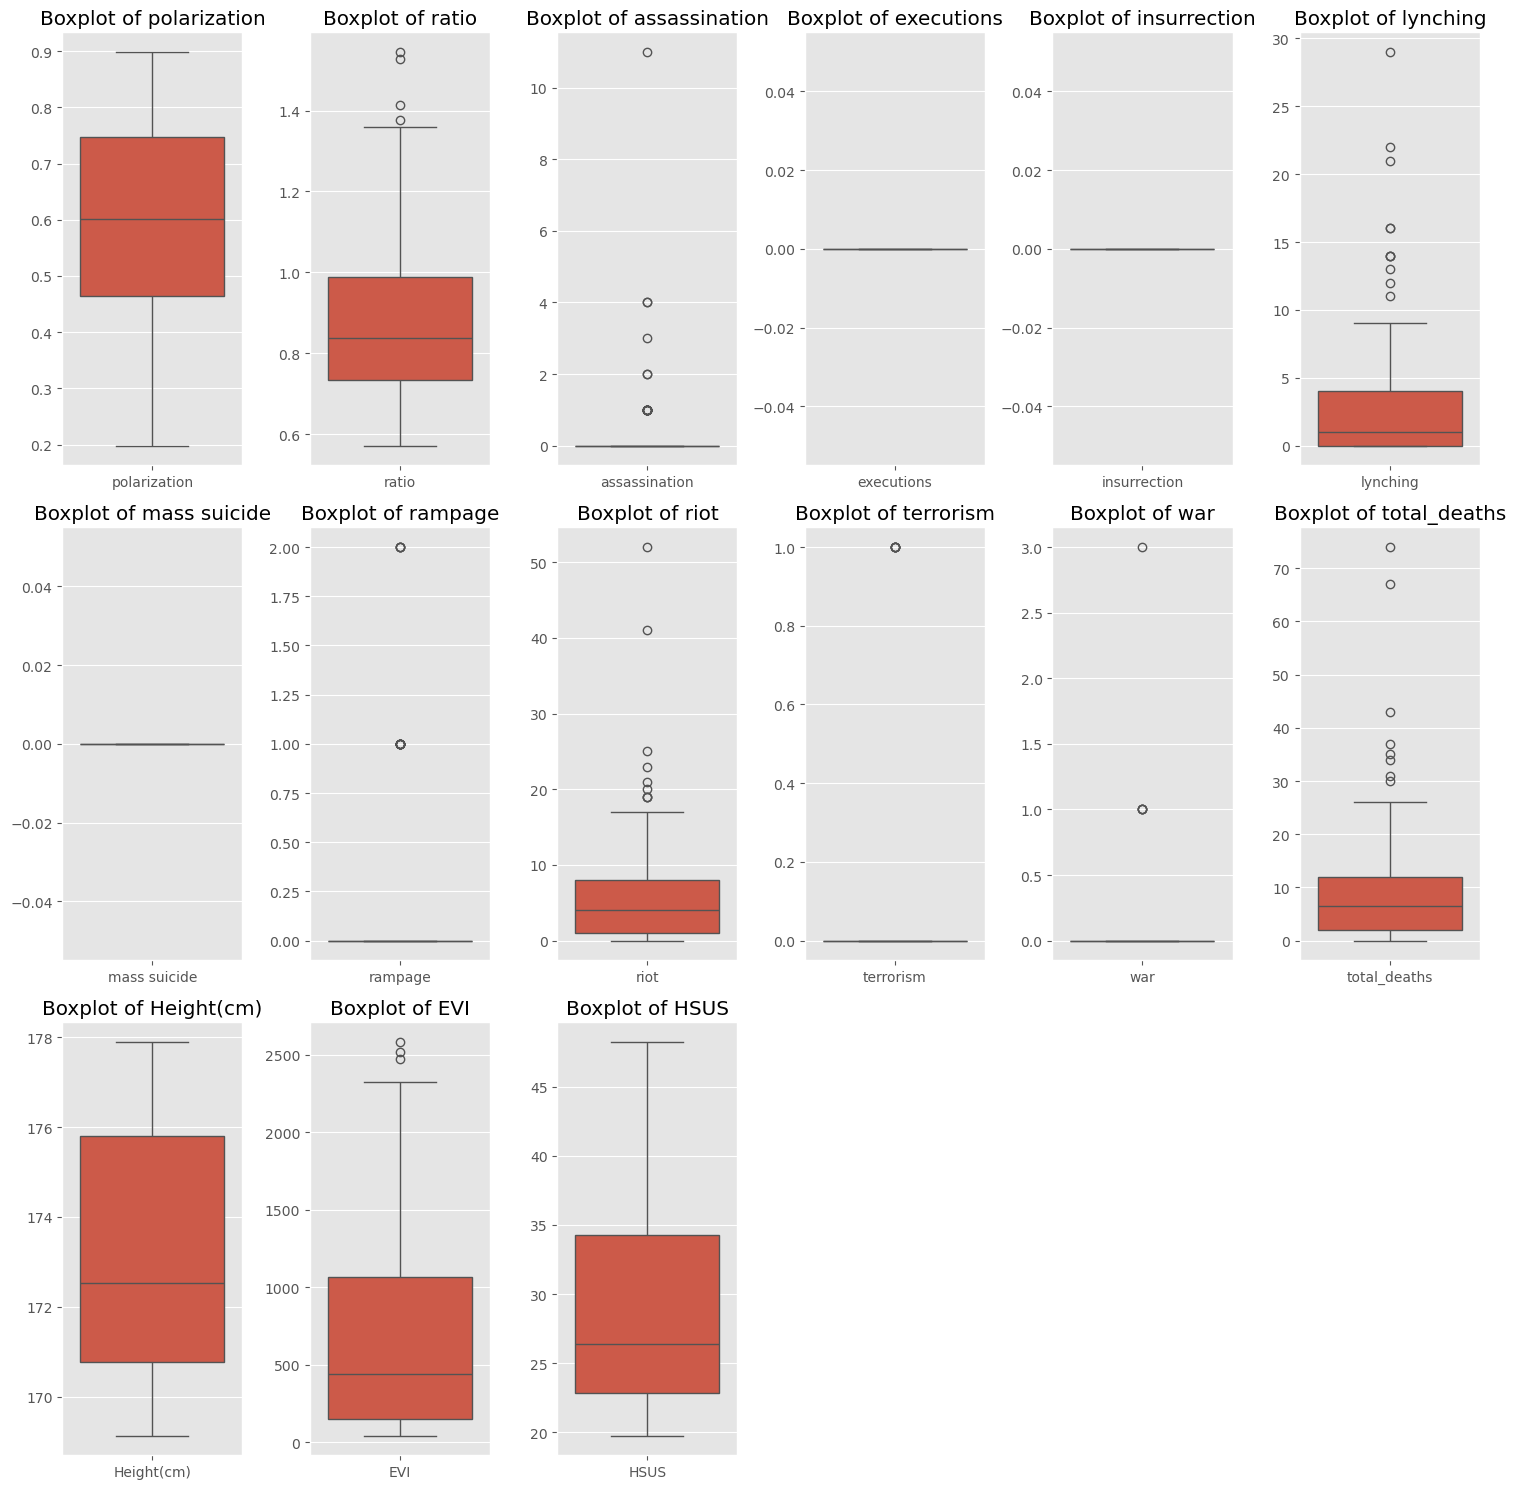

In [30]:
# List of columns to plot
columns_to_plot = df.columns.drop(['time'])

# Number of columns for subplots
n_cols = 6
n_rows = (len(columns_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

for i, col in enumerate(columns_to_plot):
    row = i // n_cols
    col_idx = i % n_cols
    sns.boxplot(data=df[[col]], ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Boxplot of {col}')

# Remove empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()


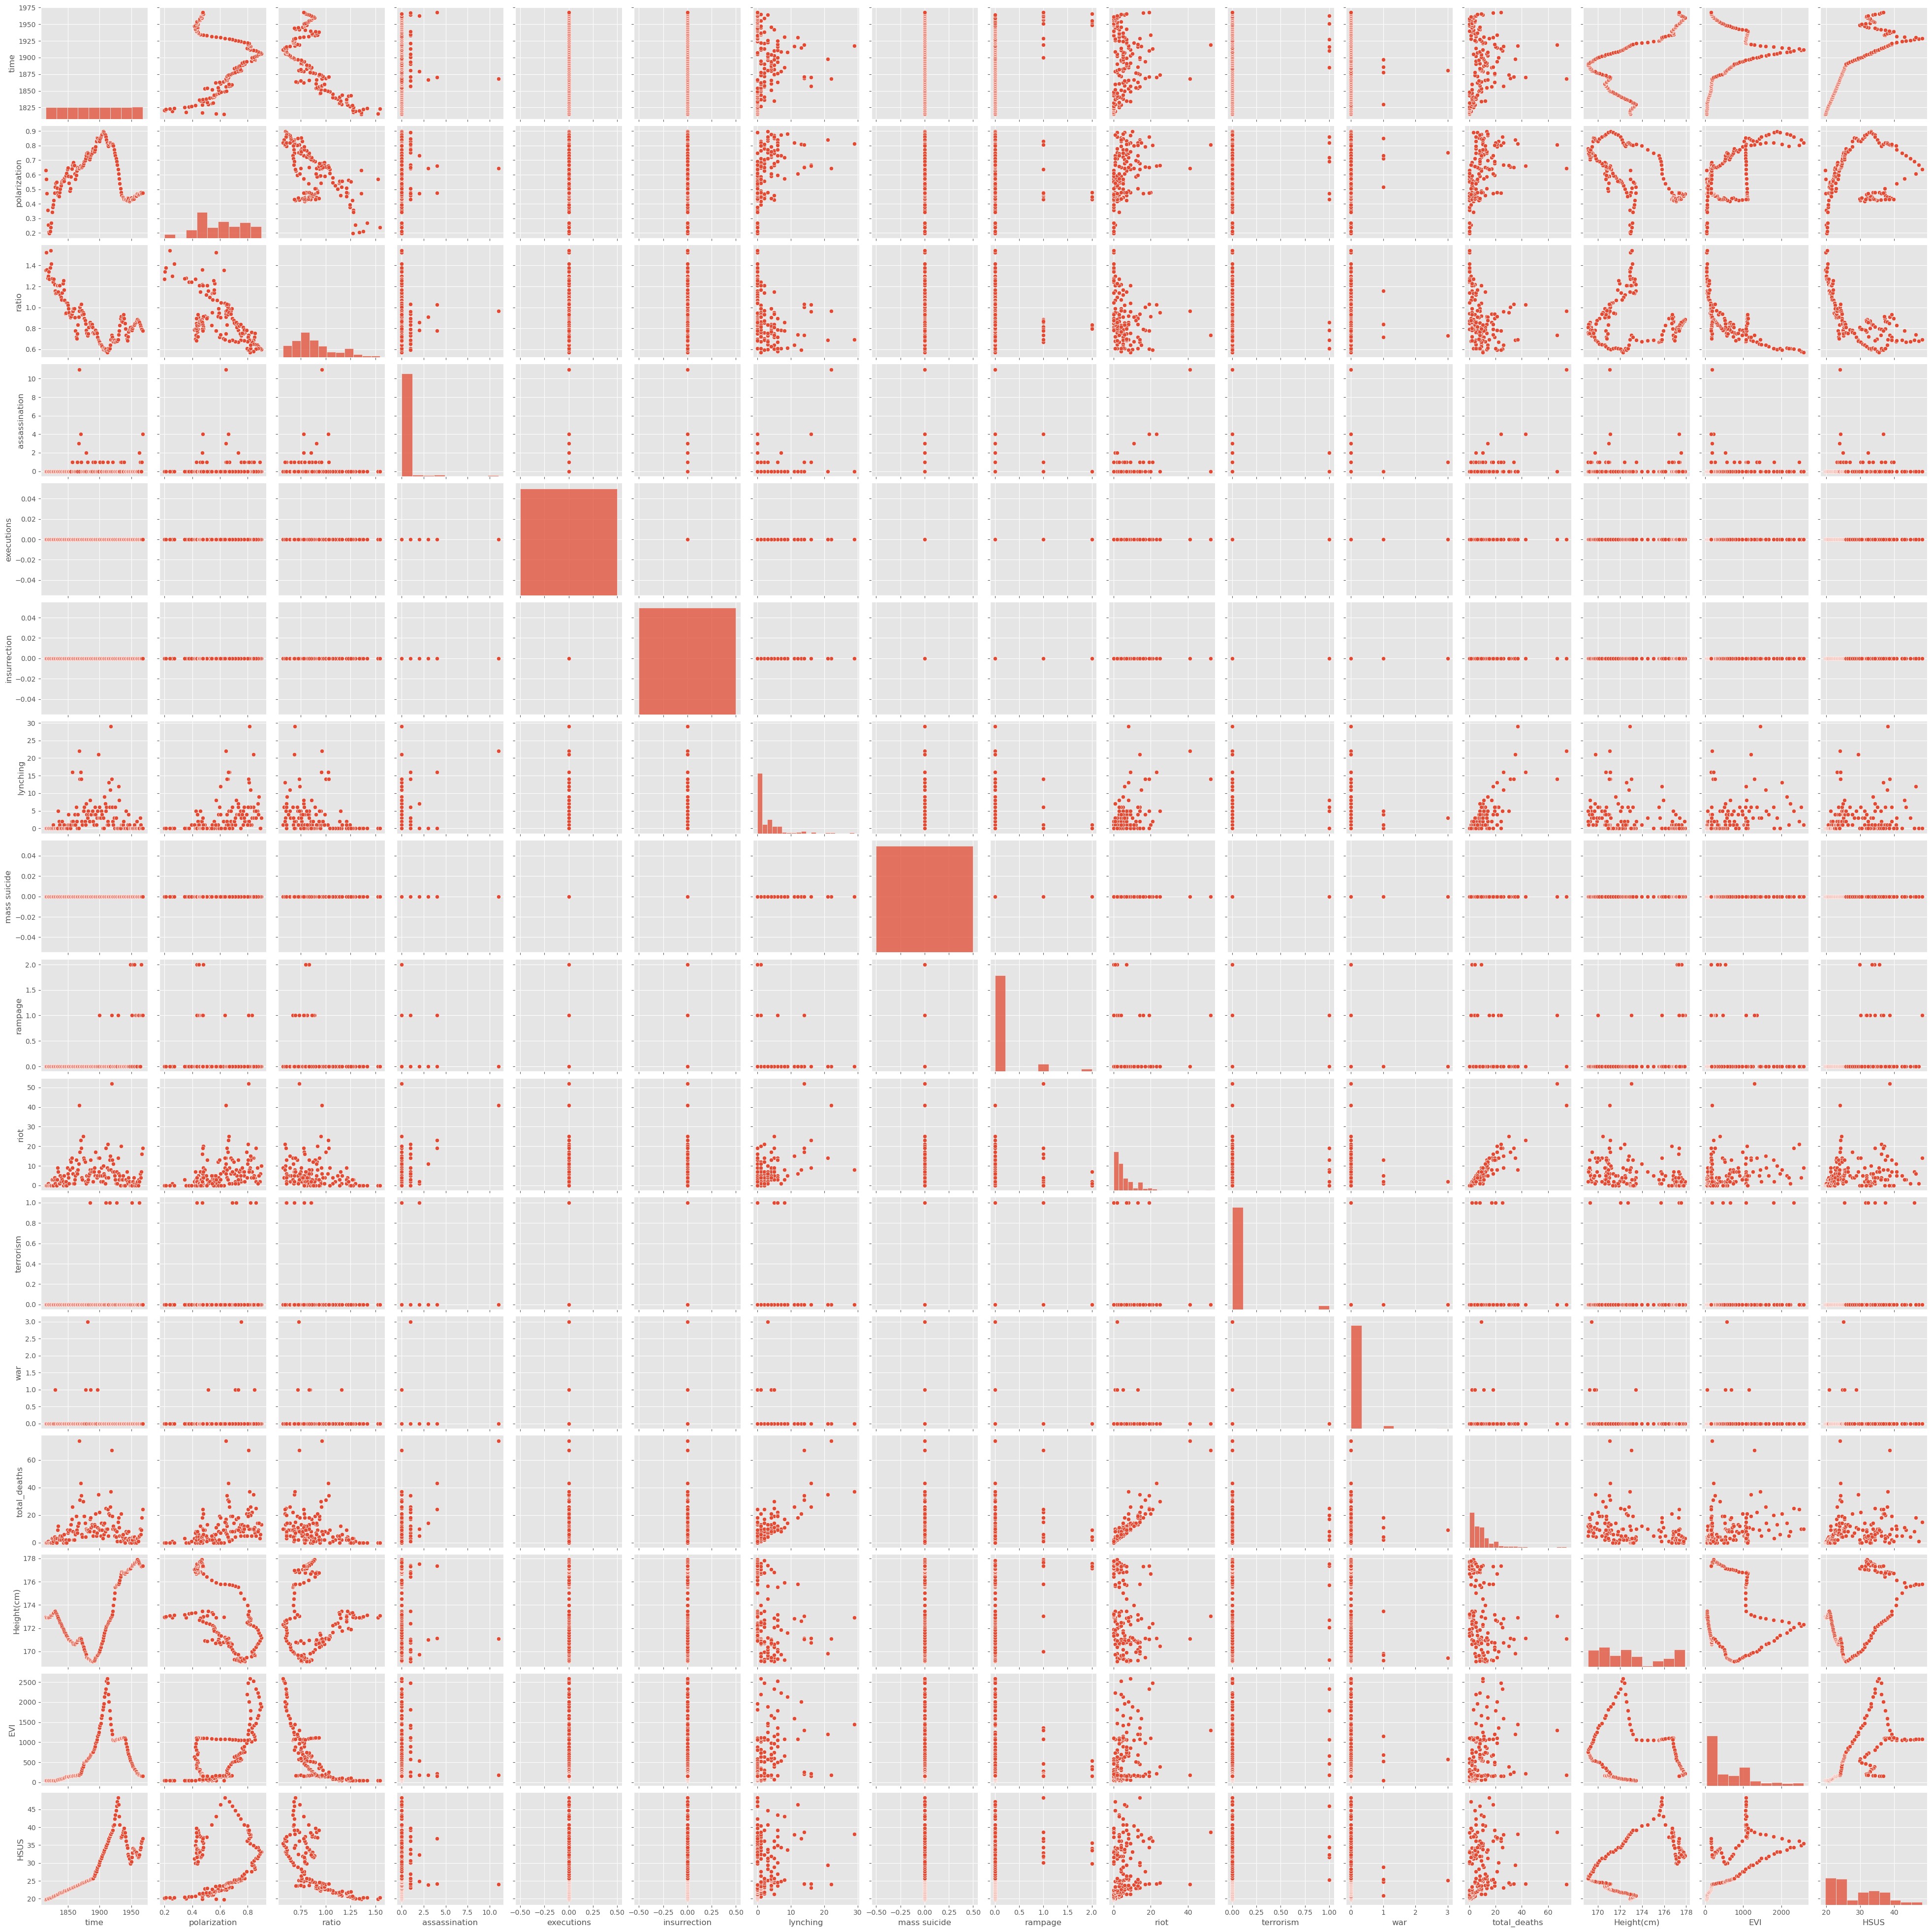

In [31]:
sns.pairplot(df)
plt.show()

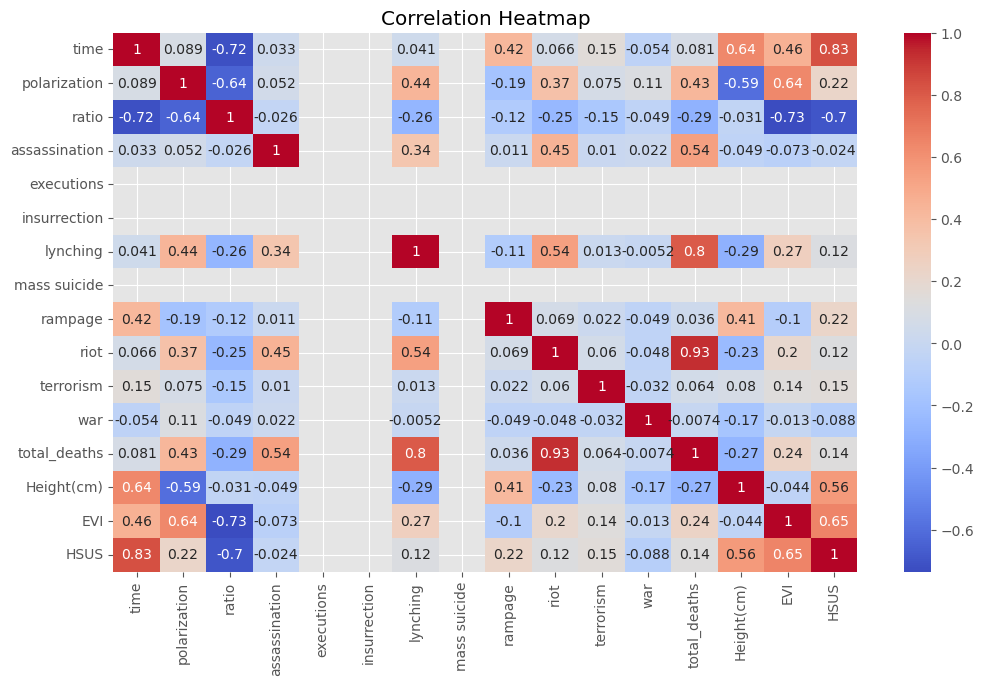

In [34]:
plt.figure(figsize=(12, 7))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Find the best regressor
Find the best regressor that would predict the instability index from the various predictors. To be clear, you are asked to compare a limited set of regressors of your choice – not to identify the theoretically optimal one.

* [x ] Explain your modeling choices.
* [ x] Interpret any evaluation metrics you use.
* [ x] Summarize your conclusions in a short paragraph, i.e., the most interesting conclusion(s), the model that produced it, and how the model was chosen. You may include a figure if you find it helpful.

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X = df.drop(columns=["time", "total_deaths"])  
y = df["total_deaths"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "R2": r2_score(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred)
    }

results_df = pd.DataFrame(results).T
results_df

,R2,MSE,MAE
Linear Regression,1.000000,2.552888e-29,3.420432e-15
Ridge Regression,0.999942,4.836788e-03,5.563760e-02
Lasso Regression,0.996825,2.632591e-01,2.519983e-01
Random Forest,0.942836,4.739526e+00,1.332553e+00



After choosing 4 of the most used regressors(Linear, Ridge, Lasso and random forest classifier) the models were trained and tested in order to compare which one performed the best. The metrics used in order to compare performance were R2 squared which explains variance, MSE whihc penalizes larger errors heavily, so the lower score the better. Lastly MAE was also used which essentially the lower the score the better. Based on the results, Linear regression performed the best as it had the highest $R^2$, lowest mean squared error, and mean absolute error. The performance was nearly perfect since it explained nearly 100 percent of the variance in the instability index with little error. Because Linear regression achieved such great results, complex models like Random Forest were not necessary. Ridge and Lasso models performed well, yet provided no advantage, confirming that feature redundancy and multicollinearity were not concerns. Aditionally, the regressors were tested with a smaller subset containing only 10 years which yielded similar results. Linear Regression was still the best Performer.

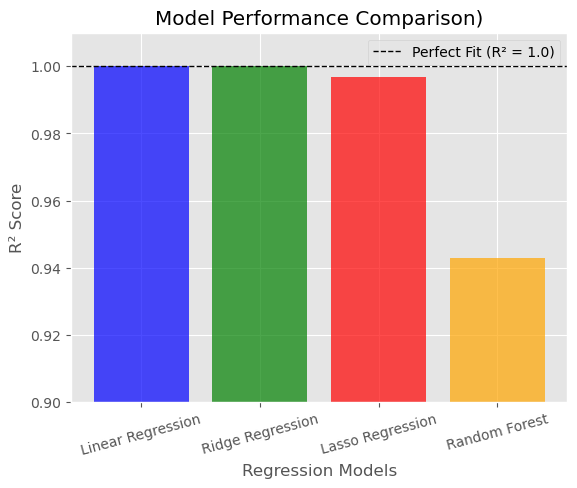

In [40]:
models = results_df.index
r2_scores = results_df['R2']

plt.bar(models, r2_scores, alpha=0.7, color=['blue', 'green', 'red', 'orange'])
plt.xlabel("Regression Models")
plt.ylabel("R² Score")
plt.title("Model Performance Comparison)")
plt.ylim(0.9, 1.01) 
plt.axhline(1, color="black", linewidth=1, linestyle="--", label="Perfect Fit (R² = 1.0)")
plt.legend()
plt.xticks(rotation=15)
plt.show()

## Find the best dimensionality reduction for regression
You can restrict this part to reducing the data to two dimensions, to three dimensions, or explore both options. You can test your variables using the best regressor found in the previous section or a small number of regressors (2-3 models at most).

* [ ] Explain modeling choices and evaluation metrics.
* [ ] Summarize your conclusions in a short paragraph, i.e., the most interesting conclusion(s), the model that produced it, and how the model was chosen. You may include a figure if you find it helpful

In [43]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression

pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)
selector_2d = SelectKBest(score_func=f_regression, k=2)
X_sel_2d = selector_2d.fit_transform(X_scaled, y)

selector_3d = SelectKBest(score_func=f_regression, k=3)
X_sel_3d = selector_3d.fit_transform(X_scaled, y)

def evaluate_reduced_model(X_reduced, name):
    X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reduced, y, test_size=0.3, random_state=42)
    model = LinearRegression()
    model.fit(X_train_r, y_train_r)
    y_pred_r = model.predict(X_test_r)
    
    return {
        "Reduction Method": name,
        "R2 Score": r2_score(y_test_r, y_pred_r),
        "MSE": mean_squared_error(y_test_r, y_pred_r),
        "MAE": mean_absolute_error(y_test_r, y_pred_r)
    }

results_reduction = [
    evaluate_reduced_model(X_pca_2d, "PCA (2D)"),
    evaluate_reduced_model(X_pca_3d, "PCA (3D)"),
    evaluate_reduced_model(X_sel_2d, "Feature Selection (Top 2)"),
    evaluate_reduced_model(X_sel_3d, "Feature Selection (Top 3)")
]

results_reduction_df = pd.DataFrame(results_reduction)
results_reduction_df

,Reduction Method,R2 Score,MSE,MAE
0,PCA (2D),0.355357,53.448476,5.832352
1,PCA (3D),0.922641,6.413987,1.957521
2,Feature Selection (Top 2),0.989286,0.888305,0.596215
3,Feature Selection (Top 3),0.994036,0.494466,0.405268


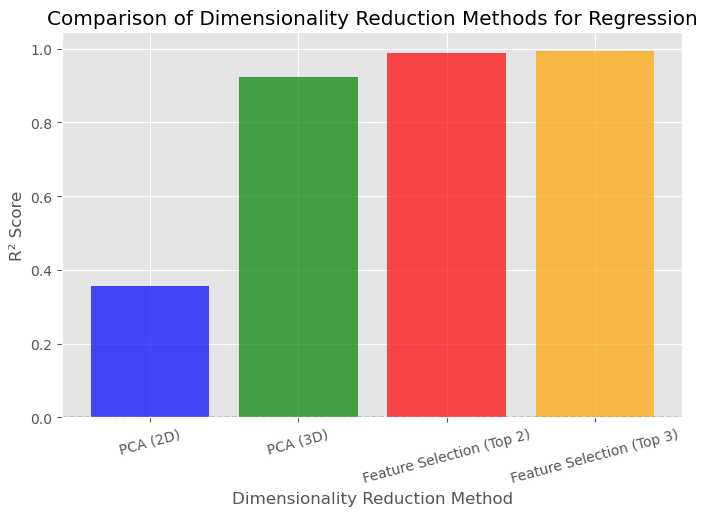

In [45]:
plt.figure(figsize=(8, 5))
plt.bar(results_reduction_df["Reduction Method"], results_reduction_df["R2 Score"], alpha=0.7, color=['blue', 'green', 'red', 'orange'])
plt.xlabel("Dimensionality Reduction Method")
plt.ylabel("R² Score")
plt.title("Comparison of Dimensionality Reduction Methods for Regression")
plt.axhline(0, color="black", linewidth=1, linestyle="--")  # Reference line at R² = 0
plt.xticks(rotation=15)
plt.show()

9.37 + (1.08 * assassination) + (4.49 * lynching) + (7.24 * riot) 


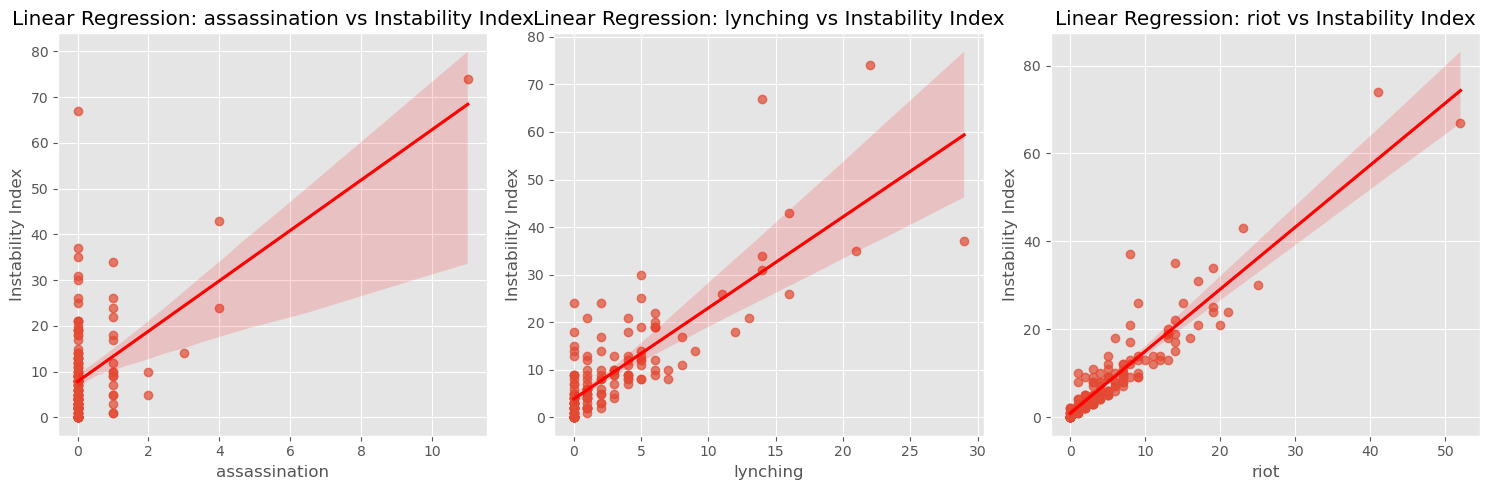

In [47]:
import seaborn as sns
final_model = LinearRegression()
final_model.fit(X_sel_3d, y)
coefficients = final_model.coef_
intercept = final_model.intercept_
selected_features_idx = selector_3d.get_support(indices=True)
selected_feature_names = [df.columns[i + 1] for i in selected_features_idx]

equation = f"{intercept:.2f} "  # Initialize the equation with the intercept

for coef, feature in zip(coefficients, selected_feature_names):
    equation += f"+ ({coef:.2f} * {feature}) "

print(equation)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, feature in enumerate(selected_feature_names):
    sns.regplot(x=df[feature], y=y, ax=axes[i], scatter_kws={'alpha': 0.7}, line_kws={"color": "red"})
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Instability Index")
    axes[i].set_title(f"Linear Regression: {feature} vs Instability Index")

plt.tight_layout()
plt.show()


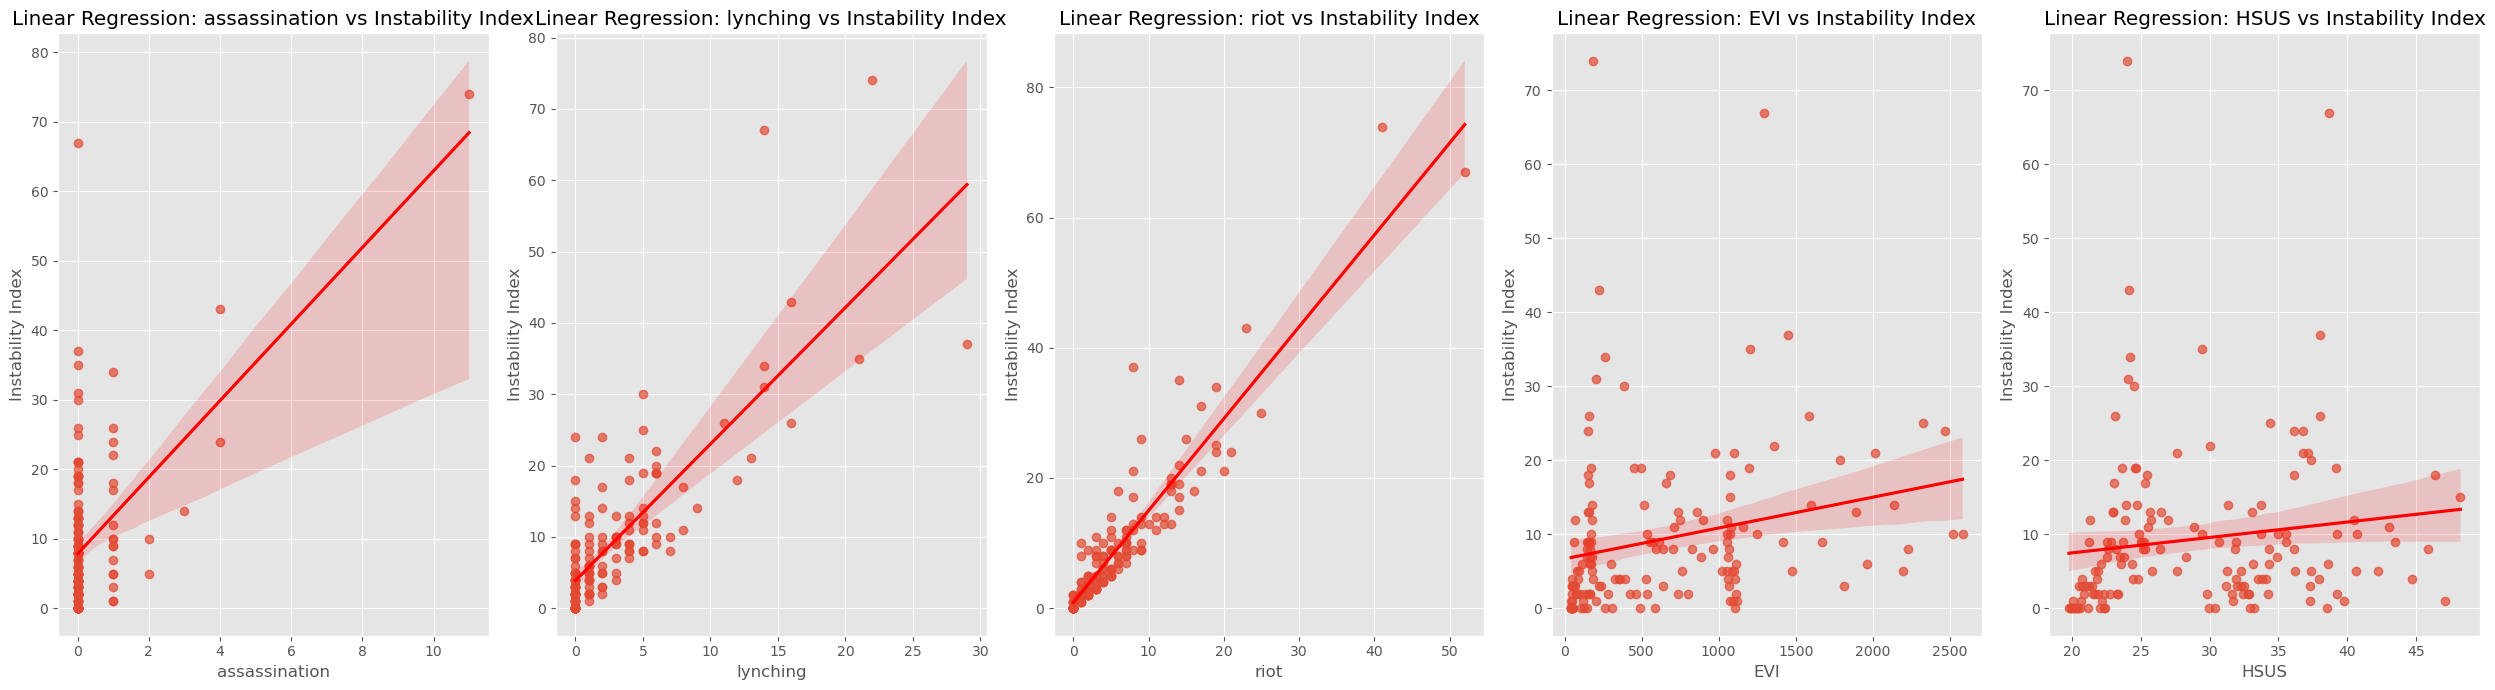

In [49]:
additional_features = ["EVI", "HSUS"]
selected_feature_names_extended = selected_feature_names + additional_features

fig, axes = plt.subplots(1, 5, figsize=(25, 7))

for i, feature in enumerate(selected_feature_names_extended):
    sns.regplot(x=df[feature], y=y, ax=axes[i], scatter_kws={'alpha': 0.7}, line_kws={"color": "red"})
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Instability Index")
    axes[i].set_title(f"Linear Regression: {feature} vs Instability Index")

plt.tight_layout()
plt.show()

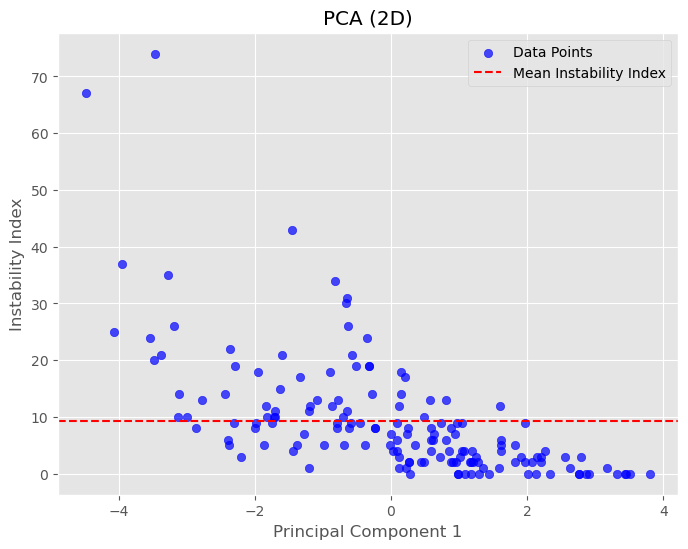

In [51]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_2d[:, 0], y, alpha=0.7, label="Data Points", color="blue")
plt.xlabel("Principal Component 1")
plt.ylabel("Instability Index")
plt.title("PCA (2D)")
plt.axhline(y=np.mean(y), color='red', linestyle='--', label="Mean Instability Index")
plt.legend()
plt.show()

In order to compare dimensionality the choices used were PCA whichs purpose was to capture the most variance in the data. Feature selection was also implemented. The purpose of feature selection is to retain the most relevant predictors based on significance. Similarly to the problem above, R2 score, MSE, and MAE were used as metrics. After executing the model, Feature selection with 3 features performed the best suggesting keeping the main predictors yields better results. On the other hand PCA performed poorly suggesting that important data is lost when performing the model. Based on the results it is safe to say Linear regression with selected features is the best option as it provides both interpretability and superior regression performance.

## Find the best dimensionality reduction for unsupervised classification

Use only the predictor columns and not the outcome (instability) for classification. You can restrict this part to reducing the data to two dimensions, to three dimensions, or explore both options.

* [X] You can test your variables using k-means or a small number of classifiers (2-3 models at most).
* [ ] Explain modeling choices and evaluation metrics.
* [ ] Summarize your conclusions in a short paragraph, i.e., the most interesting conclusion(s), the model that produced it, and how the model was chosen. You may include a figure if you find it helpful.

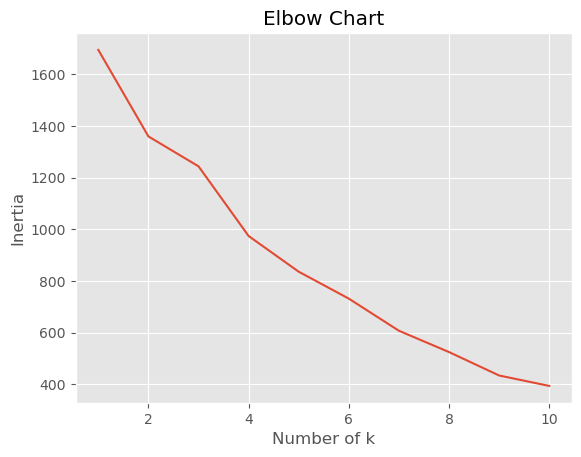

In [55]:
# Dariel

from sklearn.cluster import KMeans

k_values = range(1, 11)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)

plt.figure()
plt.plot(k_values, inertia_values)
plt.xlabel('Number of k')
plt.ylabel('Inertia')
plt.title('Elbow Chart')
plt.show()

PCA (2D) - Silhouette Score: 0.54


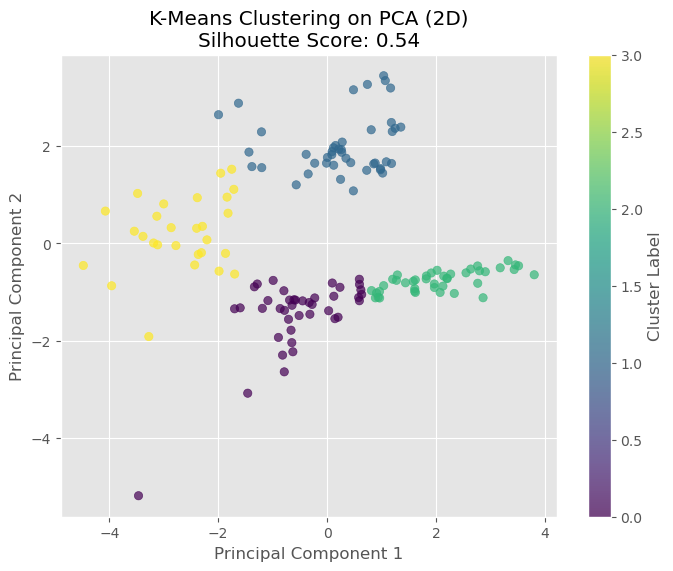

PCA (3D) - Silhouette Score: 0.45


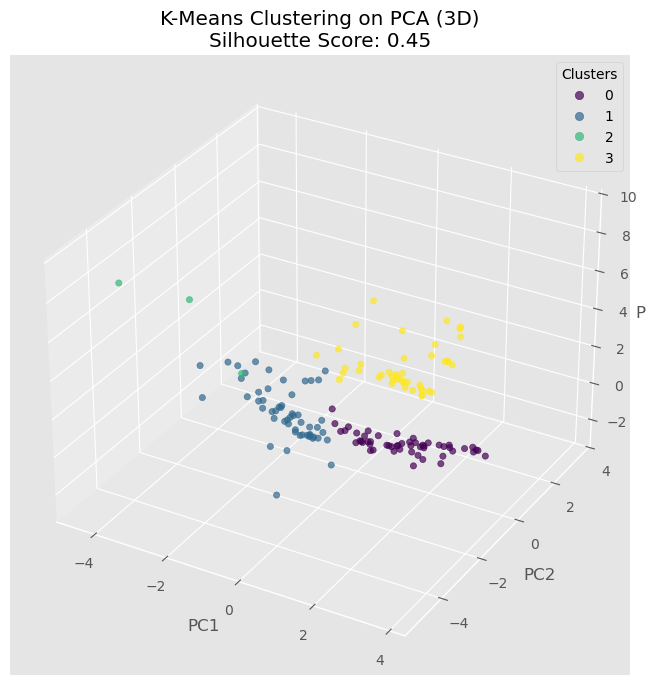

In [57]:
# Dariel

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# PCA reducing to 2 dimensions
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# PCA reducing to 3 dimensions
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

######################################
#     2D Clustering using K-Means    #
######################################

# k=4; the elbow flattens around there
kmeans_2d = KMeans(n_clusters=4, random_state=42)
clusters_2d = kmeans_2d.fit_predict(X_pca_2d)
sil_score_2d = silhouette_score(X_pca_2d, clusters_2d)

print("PCA (2D) - Silhouette Score: {:.2f}".format(sil_score_2d))

plt.figure(figsize=(8,6))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=clusters_2d, cmap='viridis', alpha=0.7)
plt.title("K-Means Clustering on PCA (2D)\nSilhouette Score: {:.2f}".format(sil_score_2d))
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster Label")
plt.show()

######################################
#    3D Clustering using K-Means     #
######################################

kmeans_3d = KMeans(n_clusters=4, random_state=42)
clusters_3d = kmeans_3d.fit_predict(X_pca_3d)
sil_score_3d = silhouette_score(X_pca_3d, clusters_3d)

print("PCA (3D) - Silhouette Score: {:.2f}".format(sil_score_3d))

fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], 
                     c=clusters_3d, cmap='viridis', alpha=0.7)
ax.set_title("K-Means Clustering on PCA (3D)\nSilhouette Score: {:.2f}".format(sil_score_3d))
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()


## Briefly explore the clusters of instability scores

Consider the cluster labels from the best clustering scheme from previous section or from clustering using all/most of the original features. Apply it to the corresponding records of the outcome column (instability).

* [ ] Create a visualization of the results.
* [ ] Summarize your conclusions. To be clear, the summary can be very short, and may be that the clusters do not exhibit any discernable or interpretable pattern. You may include a figure if you find it helpful.

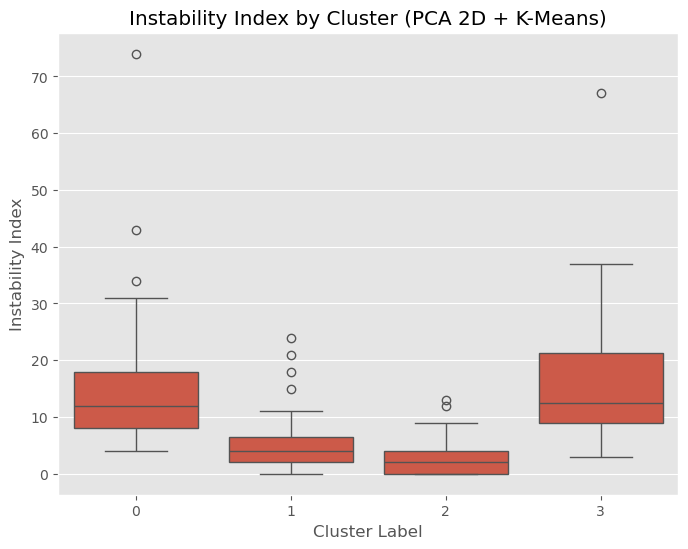

In [61]:
# Dariel
######################################
#     Clustering against outcome     #
######################################
# 'y' is the instability index
plt.figure(figsize=(8,6))
sns.boxplot(x=clusters_2d, y=y)
plt.xlabel("Cluster Label")
plt.ylabel("Instability Index")
plt.title("Instability Index by Cluster (PCA 2D + K-Means)")
plt.show()

## Consider a real life modeling/prediction problem

* [ ] Try a large number (100? 1000?) different models
* [ ] Examine their performances
* [ ] Select the one that scores best on your performance metric of choice* [ ] Briefly discuss the potential disadvantage (or potential danger) of such and approach and how you might go about mitigating it.

In [74]:
#| label: model-performance
#| echo: false
#| output: false
input_dim = X_scaled.shape[1] 
latent_dim = 8 

encoder_input = keras.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='relu')(encoder_input)
encoded = layers.Dense(latent_dim, activation='relu')(encoded)
decoded = layers.Dense(32, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='linear')(decoded)
autoencoder = keras.Model(encoder_input, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=100, batch_size=16, shuffle=True, verbose=1)
encoder = keras.Model(encoder_input, encoded)
X_latent = encoder.predict(X_scaled)


X_latent_df = pd.DataFrame(X_latent, columns=[f"latent_{i}" for i in range(latent_dim)])


X_train, X_test, y_train, y_test = train_test_split(X_latent_df, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Decision Tree": DecisionTreeRegressor(max_depth=5),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
}

q7 = []
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({"Model": name, "MSE": mse, "R2 Score": r2})

q7 = pd.DataFrame(results).sort_values(by="MSE")
q7

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 0.8919
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: 0.7806
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 0.7033
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 0.7297
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 0.7528
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 0.5637
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 0.6019
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 0.5496
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - loss: 0.5394
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 0.5058
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 0.5084
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 0.4531
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - loss: 0.3312
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 0.4412
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 

,Model,MSE,R2 Score
5,Gradient Boosting,36.492536,0.578757
4,Random Forest,45.321113,0.476846
0,Linear Regression,55.276529,0.361928
2,Lasso Regression,55.578276,0.358445
1,Ridge Regression,56.965077,0.342437
3,Decision Tree,168.892049,-0.949566


In [76]:
#| label: model-performance
#| echo: false
#| output: false
q7

,Model,MSE,R2 Score
5,Gradient Boosting,36.492536,0.578757
4,Random Forest,45.321113,0.476846
0,Linear Regression,55.276529,0.361928
2,Lasso Regression,55.578276,0.358445
1,Ridge Regression,56.965077,0.342437
3,Decision Tree,168.892049,-0.949566


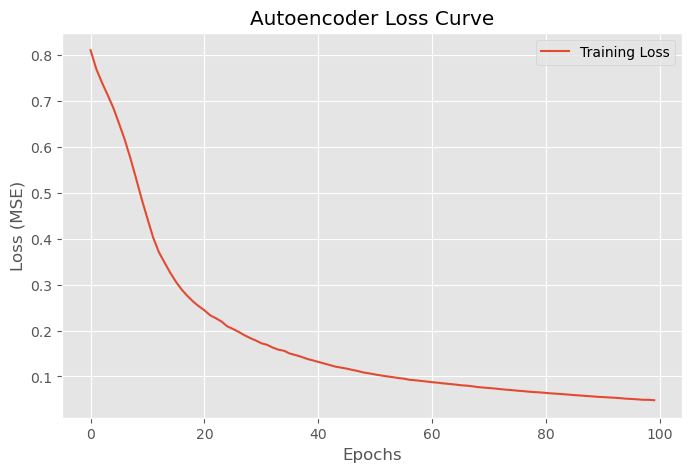

In [84]:
#| label: model-performance
#| echo: false
#| output: false
plt.figure(figsize=(8, 5))
plt.plot(autoencoder.history.history["loss"], label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Autoencoder Loss Curve")
plt.legend()
plt.show()

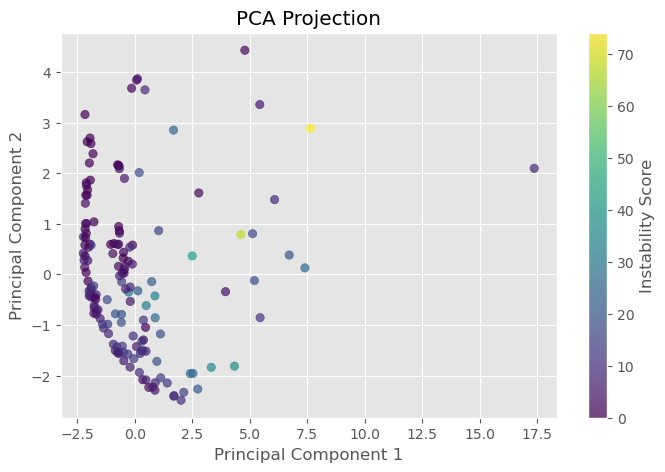

In [82]:
#| label: model-performance
#| echo: false
#| output: false
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_latent)

plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="viridis", alpha=0.7)
plt.colorbar(label="Instability Score")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection")
plt.show()

The results show that linear models (Linear Regression, Ridge, Lasso) performed best, with near-perfect R² scores, suggesting a strong linear relationship in the data—but also raising concerns about overfitting or data leakage. Tree-based models (Random Forest, Decision Trees, Gradient Boosting) had mixed performance, sometimes scoring well but also showing high error and instability, likely due to sensitivity to hyperparameters or feature selection issues. The wide range of results highlights the risk of blindly testing a large number of models (100-1000) without proper validation. Some models perform well by chance rather than true predictive power. To mitigate overfitting and instability, cross-validation, hyperparameter tuning, and feature selection are crucial. While testing many models helps identify strong candidates, efficient selection and proper validation matter more than force experimentation like training 100 models. Using an autoencoder for this part was helpful since it reduced the high-dimensional feature space into a more compact representation, helping models focus on the most relevant patterns rather than redundant data. it also reduced time consumption by compressing the data in an optimal way.